In [1]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
import numpy as np
import os
from tqdm.notebook import tqdm
import pywt
import matplotlib.pyplot as plt
from skimage.transform import resize
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

In [3]:
#Загрузка входных и зависимго признаков
X_train = np.load("data/PAMAP2_Dataset/Preprcessed/X_train_roll.npy")
X_test = np.load("data/PAMAP2_Dataset/Preprcessed/X_test_roll.npy")
y_train = np.load("data/PAMAP2_Dataset/Preprcessed/y_train_roll.npy")
y_test = np.load("data/PAMAP2_Dataset/Preprcessed/y_test_roll.npy")

print("Полезная информация:")
print(f"shapes (n_samples, n_steps, n_signals) для X_train: {X_train.shape} и X_test: {X_test.shape}")
X_all = np.concatenate([X_train, X_test])

Полезная информация:
shapes (n_samples, n_steps, n_signals) для X_train: (13130, 256, 52) и X_test: (3865, 256, 52)


In [4]:
X_train_cwt = np.load("data/PAMAP2_Dataset/Preprcessed/X_train_cwt.npy")
print(f"shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: {X_train_cwt.shape}")
X_test_cwt = np.load("data/PAMAP2_Dataset/Preprcessed/X_test_cwt.npy")
print(f"shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: {X_test_cwt.shape}")

shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: (13130, 32, 32, 52)
shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: (3865, 32, 32, 52)


In [13]:
map_y = {j:i for i,j in enumerate(set(y_train))}
map_y

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 12: 7, 13: 8, 16: 9, 17: 10, 24: 11}

In [17]:
y_train = np.array([map_y[i] for i in y_train])
y_test = np.array([map_y[i] for i in y_test])

### LSTM

In [29]:
lstm_model = Sequential()
lstm_model.add(LSTM(6,input_shape=(X_train.shape[1],X_train.shape[2])))
lstm_model.add(Dense(16 ,activation='relu'))
lstm_model.add(Dense(12, activation='softmax'))

lstm_model.summary()
lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 1416      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                112       
_________________________________________________________________
dense_11 (Dense)             (None, 12)                204       
Total params: 1,732
Trainable params: 1,732
Non-trainable params: 0
_________________________________________________________________


In [33]:
to_categorical(y_train)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [34]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=3)
history = lstm_model.fit(X_train, to_categorical(y_train), validation_split = 0.2 , epochs = 10, callbacks=[early_stopping_monitor])

Train on 10504 samples, validate on 2626 samples
Epoch 1/10
10504/10504 [==============================] - 22s 2ms/step - loss: 2.2554 - accuracy: 0.2379 - val_loss: 2.1570 - val_accuracy: 0.1668
Epoch 2/10
10504/10504 [==============================] - 19s 2ms/step - loss: 1.7377 - accuracy: 0.4189 - val_loss: 1.8766 - val_accuracy: 0.2989
Epoch 3/10
10504/10504 [==============================] - 19s 2ms/step - loss: 1.4512 - accuracy: 0.5050 - val_loss: 1.6171 - val_accuracy: 0.3317
Epoch 4/10
10504/10504 [==============================] - 19s 2ms/step - loss: 1.2539 - accuracy: 0.5650 - val_loss: 1.5450 - val_accuracy: 0.4006
Epoch 5/10
10504/10504 [==============================] - 20s 2ms/step - loss: 1.1270 - accuracy: 0.6108 - val_loss: 1.5711 - val_accuracy: 0.4448
Epoch 6/10
10504/10504 [==============================] - 20s 2ms/step - loss: 1.0247 - accuracy: 0.6393 - val_loss: 1.3182 - val_accuracy: 0.5396
Epoch 7/10
10504/10504 [==============================] - 20s 2ms/ste

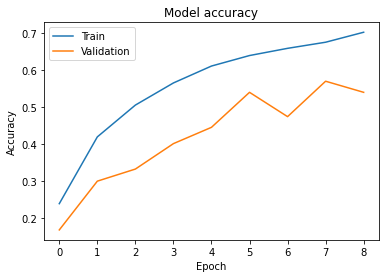

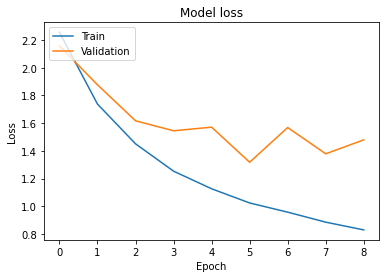

In [35]:
# taken from https://keras.io/visualization/
def quick_plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

quick_plot_history(history)

In [36]:
lstm_model.predict_classes(X_test)

array([9, 9, 9, ..., 4, 4, 4], dtype=int64)

Accuracy: 46.78%


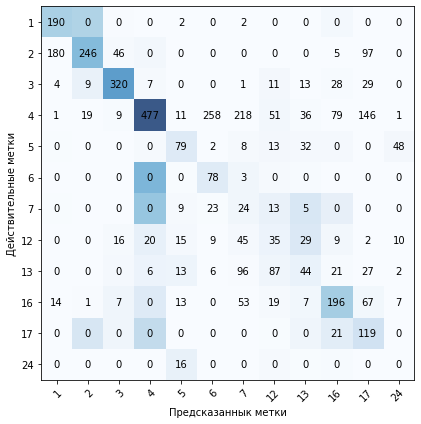

In [37]:
# make predictions for test data
y_pred = lstm_model.predict_classes(X_test)
# determine the total accuracy 
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

create_confusion_matrix(y_pred, y_test)

### CNN + WT

In [18]:
def build_cnn_model(activation, input_shape):
    model = Sequential()
    
    # 2 Convolution layer with Max polling
    model.add(Conv2D(32, 5, activation = activation, padding = 'same', input_shape = input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 5, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D())  
    model.add(Flatten())
    
    # 3 Full connected layer
    model.add(Dense(128, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(54, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(12, activation = 'softmax')) # 12 classes
    
    # summarize the model
    print(model.summary())
    return model

def compile_and_fit_model(model, X_train, y_train, X_test, y_test, batch_size, n_epochs):

    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])
    
    # define callbacks
    callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_sparse_categorical_accuracy', save_best_only=True)]
    
    # fit the model
    history = model.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))
    
    return model, history

# shape of the input images
input_shape = (X_train_cwt.shape[1], X_train_cwt.shape[2], X_train_cwt.shape[3])

# create cnn model
cnn_model = build_cnn_model("relu", input_shape)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        41632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               524416    
_________________________________________________________________
dense_8 (Dense)              (None, 54)               

In [19]:
# train cnn model
trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_train_cwt, y_train, X_test_cwt, y_test, 368, 10)

Train on 13130 samples, validate on 3865 samples
Epoch 1/10
13130/13130 [==============================] - 50s 4ms/step - loss: 1.5094 - sparse_categorical_accuracy: 0.4812 - val_loss: 1.3315 - val_sparse_categorical_accuracy: 0.4875
Epoch 2/10
13130/13130 [==============================] - 49s 4ms/step - loss: 0.7479 - sparse_categorical_accuracy: 0.7810 - val_loss: 1.1581 - val_sparse_categorical_accuracy: 0.6629
Epoch 3/10
13130/13130 [==============================] - 49s 4ms/step - loss: 0.4839 - sparse_categorical_accuracy: 0.8609 - val_loss: 1.1653 - val_sparse_categorical_accuracy: 0.7125
Epoch 4/10
13130/13130 [==============================] - 49s 4ms/step - loss: 0.3528 - sparse_categorical_accuracy: 0.8976 - val_loss: 1.2723 - val_sparse_categorical_accuracy: 0.6660
Epoch 5/10
13130/13130 [==============================] - 50s 4ms/step - loss: 0.2928 - sparse_categorical_accuracy: 0.9159 - val_loss: 1.3817 - val_sparse_categorical_accuracy: 0.6939
Epoch 6/10
13130/13130 [==

Accuracy: 66.65%


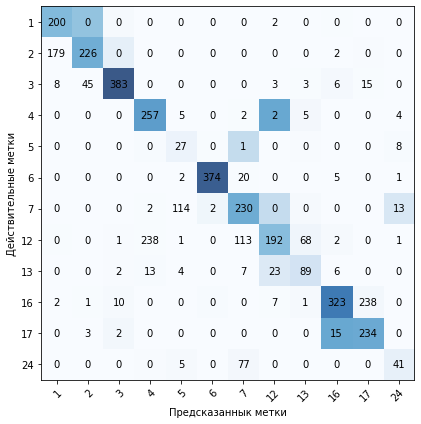

In [22]:
from sklearn import metrics

LABEL_NAMES = map_y.keys()

def create_confusion_matrix(y_pred, y_test):    
    #calculate the confusion matrix
    confmat = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(confmat, cmap=plt.cm.Blues, alpha=0.8)

    n_labels = len(LABEL_NAMES)
    ax.set_xticks(np.arange(n_labels))
    ax.set_yticks(np.arange(n_labels))
    ax.set_xticklabels(LABEL_NAMES)
    ax.set_yticklabels(LABEL_NAMES)

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # loop over data dimensions and create text annotations.
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=i, y=j, s=confmat[i, j], va='center', ha='center')
    

    
    ax.set_xlabel('Предсказаннык метки')
    ax.set_ylabel('Действительные метки')

    plt.tight_layout()
    plt.show()

# make predictions for test data
y_pred = trained_cnn_model.predict_classes(X_test_cwt)
# determine the total accuracy 
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

create_confusion_matrix(y_pred, y_test)

In [23]:
accuracy_train = cnn_history.history.keys()

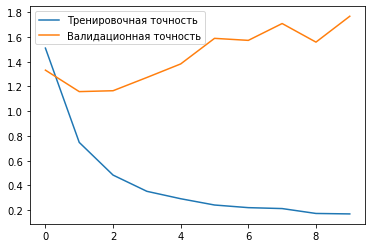

In [39]:
plt.plot(cnn_history.history['loss'], label = 'Тренировочная точность')
plt.plot(cnn_history.history['val_loss'], label = 'Валидационная точность')
plt.legend()
plt.show()